# 삼중항 손실(triplet loss)이 있는 샴 네트워크(Siamese Network)를 사용한 이미지 유사도 추정

Siamese Networks는 중복 감지, anomaly detection, 얼굴 인식과 같은 다양한 사용 사례에 적용될 수 있습니다.

이 예에서는 3개의 동일한 subnetwork가 있는 샴 네트워크를 사용합니다. 모델에 3개의 이미지를 제공합니다. 여기서
그 중 두 개는 비슷할 것이고(_anchor_ 및 _positive_ sample), 세 번째는 관련이 없을 것입니다(_negative_ sample).
우리의 목표는 모델이 이미지 간의 유사성을 추정하는 방법을 배우도록 하는  것입니다.

네트워크가 학습하기 위해 삼중항 손실 함수(triple loss function)를 사용합니다.

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

이 예시는 [Totally Looks Like dataset](https://sites.google.com/view/totally-looks-like-dataset)를 사용합니다.
[Rosenfeld et al., 2018](https://arxiv.org/pdf/1803.01485v3.pdf).  

- 데이터 세트에는 6016개의 이미지 쌍이 포함되어 있습니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.utils import plot_model
import time

target_shape = (200, 200)

## dataset load

*Totally Looking Like* 데이터세트를 로드하고 압축을 풉니다.

데이터세트는 두 개의 개별 파일로 구성됩니다.

* `left.zip`에는 anchor로 사용할 이미지가 포함되어 있습니다.
* `right.zip`에는 positive 샘플(앵커처럼 보이는 이미지)로 사용할 이미지가 포함되어 있습니다.

In [2]:
cache_dir = Path("/content/")
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

cache_dir, anchor_images_path, positive_images_path

(PosixPath('/content'),
 PosixPath('/content/left'),
 PosixPath('/content/right'))

In [3]:
#OYJ gdrive에서 file download 및 압축 해제 
!gdown 1RxrOFgTLcv_f0HLwJeGOq4kJEHVgC4m7
!gdown 1--Us3zRNRGYWNpWJBlIkXEjiNmo39_Ue

!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1RxrOFgTLcv_f0HLwJeGOq4kJEHVgC4m7
To: /content/right.zip
100% 104M/104M [00:00<00:00, 120MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1--Us3zRNRGYWNpWJBlIkXEjiNmo39_Ue
To: /content/left.zip
100% 104M/104M [00:00<00:00, 122MB/s] 


In [4]:
# !gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
# !gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW

## 데이터 준비

우리는 `tf.data` 파이프라인을 사용하여 데이터를 로드하고 Siamese 네트워크를 훈련하는 데 필요한 삼중항을 생성할 것입니다.

anchor, positive, 및 negative 파일 이름이 소스로 포함된 압축 목록을 사용하여 파이프라인을 설정합니다. 파이프라인은 해당 이미지를 로드하고 사전 처리합니다.

In [5]:
def preprocess_image(filename):
    """
   지정된 파일을 JPEG 이미지로 로드하고 사전 처리한 다음 target shape으로 크기를 조정합니다.
    """
    image_string = tf.io.read_file(filename)   #Reads the contents of file.
    image = tf.image.decode_jpeg(image_string, channels=3)  #Decode a JPEG-encoded image to a uint8 tensor.
    image = tf.image.convert_image_dtype(image, tf.float32) #Convert image to dtype, scaling its values if needed.
    image = tf.image.resize(image, target_shape) # Resize images to size using the specified method
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    세 개의 이미지에 해당하는 파일 이름이 주어지면 로드하고 전처리합니다.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

anchor,  positive 및 negative 이미지 파일 이름이 소스로 포함된 압축 목록을 사용하여 데이터 파이프라인을 설정해 보겠습니다. 파이프라인의 출력에는 모든 이미지가 load 되고 사전 처리된 동일한 triplet이 포함됩니다.

앵커 이미지와 포지티브 이미지가 모두 정렬된 순서로 load 되었는지 확인하여 함께 일치시킬 수 있도록 해야 합니다.

In [6]:
os.listdir(anchor_images_path)[:5], os.listdir(positive_images_path)[:5]

(['03989.jpg', '04968.jpg', '01852.jpg', '04042.jpg', '02581.jpg'],
 ['03989.jpg', '04968.jpg', '01852.jpg', '04042.jpg', '02581.jpg'])

In [7]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

print(len(anchor_images), len(positive_images))
anchor_images[:5], positive_images[:5]

6016 6016


(['/content/left/00000.jpg',
  '/content/left/00001.jpg',
  '/content/left/00002.jpg',
  '/content/left/00003.jpg',
  '/content/left/00004.jpg'],
 ['/content/right/00000.jpg',
  '/content/right/00001.jpg',
  '/content/right/00002.jpg',
  '/content/right/00003.jpg',
  '/content/right/00004.jpg'])

anchor image와 positive image가 정렬되어 있는지 확인

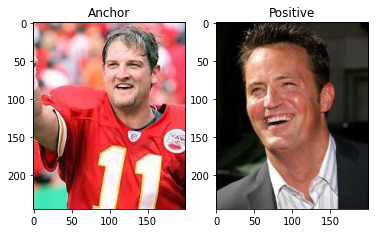

In [8]:
img1 = Image.open(anchor_images[0])
img2 = Image.open(positive_images[0])
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Anchor')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Positive')
plt.show()

Anchor / Positive Data generator 생성

In [9]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

for img1, img2 in zip(anchor_dataset.take(5), positive_dataset.take(5)):
    print(img1, img2)

tf.Tensor(b'/content/left/00000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00001.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00001.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00002.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00002.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00003.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00003.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00004.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00004.jpg', shape=(), dtype=string)


negative 이미지 목록을 생성하기 위해 사용 가능한 이미지 목록을 무작위로 만들고 함께 연결합니다.

In [10]:
# anchor_images 목록과 positive_images 목록을 shuffle 후 add 하여 negative_images  목록 생성 
rng1 = np.random.RandomState(seed=42)
rng1.shuffle(anchor_images)
rng1.shuffle(positive_images)

negative_images = anchor_images + positive_images
print(len(negative_images))

# negative_images 목록 shuffle
# rng2 = np.random.RandomState(seed=32)
# rng2.shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

for img1, img2 in zip(anchor_dataset.take(5), negative_dataset .take(5)):
    print(img1, img2)

12032
tf.Tensor(b'/content/left/00000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/01211.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00001.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/03071.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00002.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/00293.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00003.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/03269.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00004.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/05513.jpg', shape=(), dtype=string)


Anchor와 Negative Image 가 불일치 하는지 확인

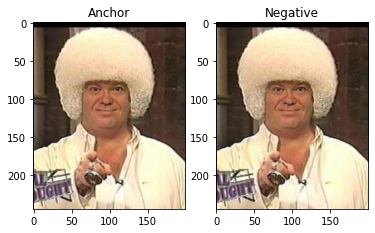

In [11]:
img1 = Image.open(anchor_images[0])
img2 = Image.open(negative_images[0])
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Anchor')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Negative')
plt.show()

In [12]:
len(anchor_dataset), len(positive_dataset), len(negative_dataset)

(6016, 6016, 12032)

Triple Data의 generator 생성

In [13]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

image_count = len(anchor_dataset)

#데이터 세트를 학습 및 검증으로 분할
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False).prefetch(8)
val_dataset = val_dataset.batch(32, drop_remainder=False).prefetch(8)

train_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>)

Triplelet의 몇 가지 예를 살펴봅니다. 세 번째 이미지는 항상 다른 반면 처음 두 이미지는 유사한 것을 확인합니다.

In [14]:
def visualize(anchor, positive, negative):
    """제공된 배치에서 몇 개의 트리플렛을 시각화"""

    def show(ax, image, title):
        ax.imshow(image)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i], 'anchor')
        show(axs[i, 1], positive[i], 'positive')
        show(axs[i, 2], negative[i], 'negative')

as_numpy_iterator 메소드는 Dataset의 모든 요소를 numpy로 변환하는 iterator를 리턴

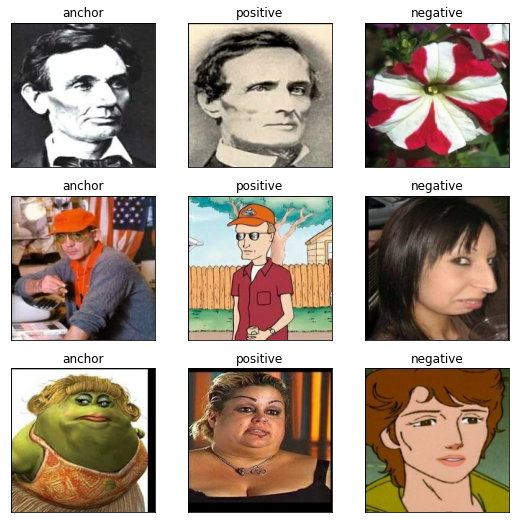

In [15]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## 임베딩 생성기 모델 설정

Siamese 네트워크는 삼중항의 각 이미지에 대한 임베딩을 생성합니다. 이를 위해 ImageNet에서 사전 훈련된 ResNet50 모델을 사용하고 몇 개의 'Dense' 레이어를 연결하여 이러한 임베딩을 분리하는 방법을 배울 것입니다.

모델의 모든 레이어의 가중치를 `conv5_block1_out` 레이어까지 고정합니다.
이는 모델이 이미 학습한 가중치에 영향을 미치지 않도록 하는 데 중요합니다.
우리는 훈련 중에 가중치를 미세 조정할 수 있도록 맨 아래 몇 개의 레이어를 훈련 가능한 상태로 둘 것입니다.

In [16]:
target_shape + (3,)

(200, 200, 3)

In [17]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
base_cnn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
flatten = layers.Flatten()(base_cnn.output)
x = layers.Dense(512, activation="relu")(flatten)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(256)(x)

#Resnet50을 특성 추출기로 사용한 embedding 출력
embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True  # 이 block 이후로는 layer.trainable을 True로 변경
    layer.trainable = trainable

## 샴 네트워크 모델 설정

샴 네트워크는 각각의 삼중항 이미지를 입력으로 받아 임베딩을 생성하고 앵커와 포지티브 임베딩 사이의 거리와 앵커와 네거티브 임베딩 사이의 거리를 출력합니다.

거리를 계산하기 위해 두 값을 튜플로 반환하는 사용자 지정 레이어 'DistanceLayer'를 사용할 수 있습니다.

In [19]:
class DistanceLayer(layers.Layer):
    """
    이 레이어는 앵커 임베딩과 포지티브 임베딩, 앵커 임베딩과 
    네거티브 임베딩 사이의 거리를 계산하는 역할을 합니다.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return (ap_distance, an_distance)

# 3개의 Input images
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# 3 개의 image의 embedding을 DistanceLayer의 입력으로 공급
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [20]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                            

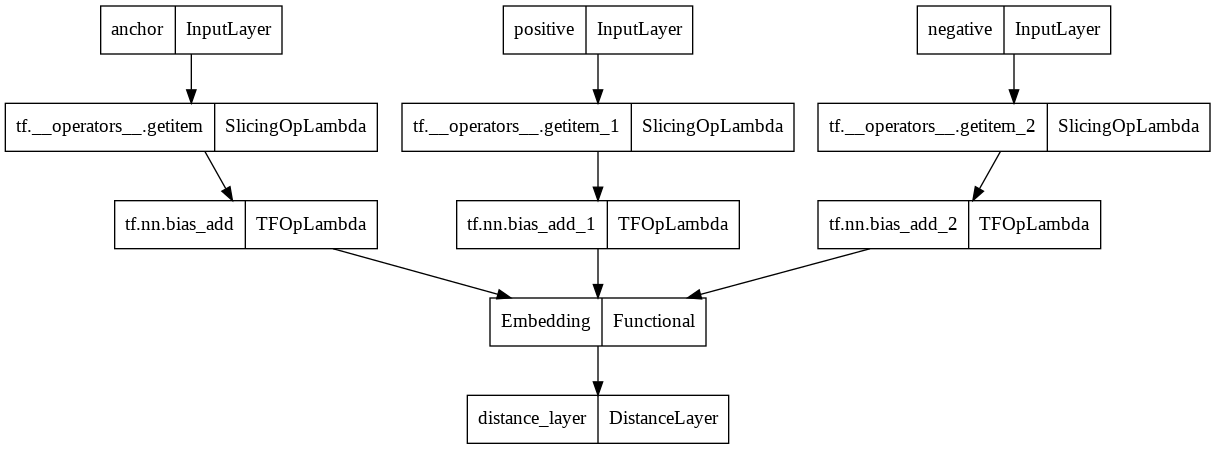

In [21]:
plot_model(siamese_network)

## Putting everything together

이제 Siamese 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산할 수 있도록 사용자 지정 훈련 루프가 있는 모델을 구현해야 합니다.

훈련 과정의 손실을 추적하기 위해 'Mean' 메트릭 인스턴스를 생성해 보겠습니다.

In [22]:
class SiameseModel(Model):
    """사용자 정의 훈련 및 테스트 루프가 있는 샴 네트워크 모델.
    샴 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산합니다.

    삼중항 손실은 다음과 같이 정의:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):

        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # 손실 메트릭을 업데이트하고 반환
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # 네트워크의 출력은 앵커와 포지티브, 앵커와 네거티브 사이의 
        # 거리를 포함하는 튜플입니다.
        ap_distance, an_distance = self.siamese_network(data)

        # 두 거리를 빼고 음수 값을 얻지 않도록 하여 삼중항 손실을 계산합니다.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # 여기에 메트릭을 나열하면 `reset_states()`가 자동으로 호출
        return [self.loss_tracker]

## Training

In [23]:
s = time.time()
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history = siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
151/151 [==============================] - 64s 336ms/step - loss: 0.5019 - val_loss: 0.3996
Epoch 2/20
151/151 [==============================] - 50s 329ms/step - loss: 0.3936 - val_loss: 0.3611
Epoch 3/20
151/151 [==============================] - 48s 316ms/step - loss: 0.3645 - val_loss: 0.3247
Epoch 4/20
151/151 [==============================] - 48s 316ms/step - loss: 0.3482 - val_loss: 0.3188
Epoch 5/20
151/151 [==============================] - 48s 317ms/step - loss: 0.3280 - val_loss: 0.3288
Epoch 6/20
151/151 [==============================] - 48s 316ms/step - loss: 0.3168 - val_loss: 0.3161
Epoch 7/20
151/151 [==============================] - 48s 316ms/step - loss: 0.2961 - val_loss: 0.3222
Epoch 8/20
151/151 [==============================] - 48s 315ms/step - loss: 0.2928 - val_loss: 0.3096
Epoch 9/20
151/151 [==============================] - 48s 316ms/step - loss: 0.2875 - val_loss: 0.2917
Epoch 10/20
151/151 [==============================] - 48s 318ms/step - l

In [24]:
print("경과 시간 (분):", (time.time() - s)/60)

경과 시간 (분): 16.809153898557028


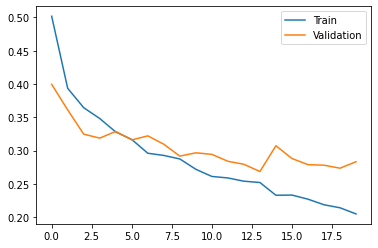

In [25]:
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()

In [52]:
siamese_model.save_weights("siamese_weight.h5")

## 네트워크가 학습한 내용 검사

이제 네트워크가 유사한 이미지에 속하는지 여부에 따라 임베딩을 분리하는 방법을 학습한 것을 확인할 수 있습니다.

[코사인 유사도](https://en.wikipedia.org/wiki/Cosine_similarity)를 사용하여 임베딩 간의 유사도를 측정할 수 있습니다.

데이터 세트에서 샘플을 선택하여 각 이미지에 대해 생성된 임베딩 간의 유사성을 확인하겠습니다.

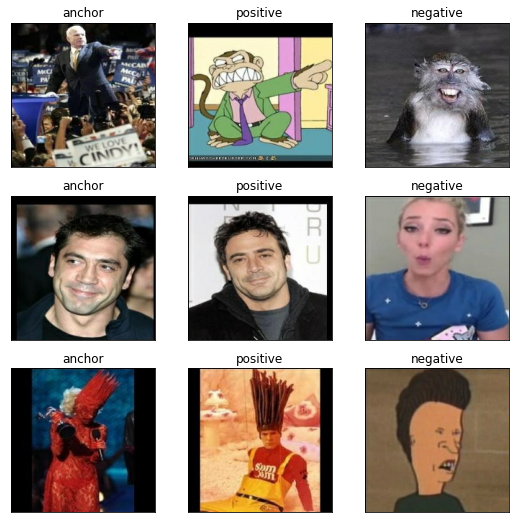

In [26]:
sample = next(iter(train_dataset))
visualize(*sample)

마지막으로 앵커와 포지티브 이미지 간의 코사인 유사도를 계산하고 앵커와 네거티브 이미지 간의 유사도와 비교할 수 있습니다.

앵커와 포지티브 이미지 사이의 유사도가 앵커와 네거티브 이미지 간의 유사도보다 클 것으로 예상 합니다.

In [27]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9933808
Negative similarity 0.9903555


전체 Train set 에 대한 유사도 계산

In [28]:
positive_similarities = []
negative_similarities = []

for anchor, positive, negative in train_dataset:
    anchor_embedding, positive_embedding, negative_embedding = (
        embedding(resnet.preprocess_input(anchor)),
        embedding(resnet.preprocess_input(positive)),
        embedding(resnet.preprocess_input(negative)),
    )

    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    positive_similarities.append(positive_similarity.numpy())

    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    negative_similarities.append(negative_similarity.numpy())

positive similarity의 최소값 : 0.9903888


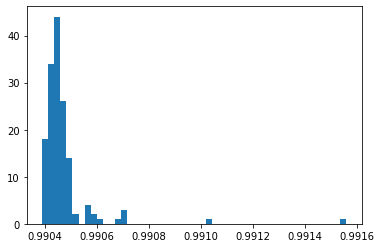

In [29]:
plt.hist(positive_similarities, bins=50);
print("positive similarity의 최소값 :", min(positive_similarities))

negative similarity의 최대값 : 0.99065554


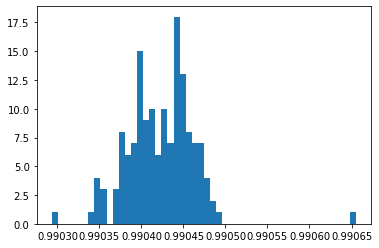

In [30]:
plt.hist(negative_similarities, bins=50);
print("negative similarity의 최대값 :", max(negative_similarities))

 위 plot 에서 threshold를 정하여 이진 분류 모델 작성

In [38]:
threshold = 0.990

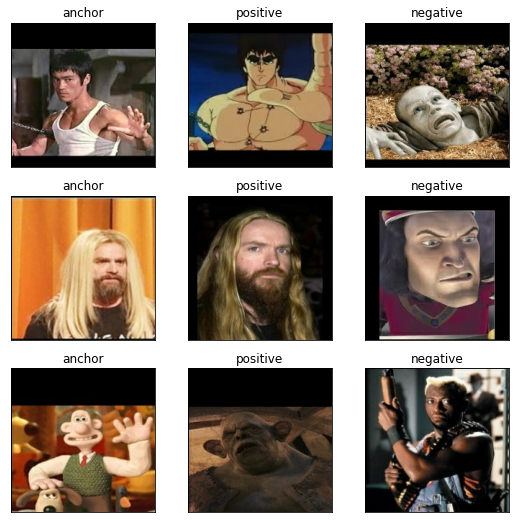

In [39]:
sample = next(iter(val_dataset))
visualize(*sample)

In [40]:
anchor, positive, negative = sample

anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor[0:1])),
    embedding(resnet.preprocess_input(positive[0:1])),
    embedding(resnet.preprocess_input(negative[0:1])),
)

In [41]:
similarity_score = cosine_similarity(anchor_embedding, positive_embedding)

In [42]:
print("임계값 :", threshold)
if  similarity_score > threshold:
    print("유사도 : {similarity_score} ==> same person")
else:
    print("유사도 : {similarity_score} ==> different person")

임계값 : 0.99
유사도 : {similarity_score} ==> same person


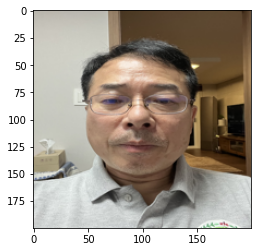

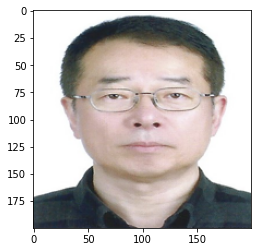

In [53]:
img = Image.open('oyjselfi.jpg').resize((200, 200))
plt.imshow(img)
plt.show()

img = np.expand_dims(np.array(img), axis=0)
anchor = embedding(resnet.preprocess_input(img))

img1 = Image.open('PHOTO오영제.jpg').resize((200, 200))
plt.imshow(img1)
plt.show()

img1 = np.expand_dims(np.array(img1), axis=0)
positive = embedding(resnet.preprocess_input(img1))

In [54]:
similarity_score = cosine_similarity(anchor_embedding, positive_embedding)

print("임계값 :", threshold)
if  similarity_score > threshold:
    print("유사도 : {similarity_score} ==> same person")
else:
    print("유사도 : {similarity_score} ==> different person")

임계값 : 0.99
유사도 : {similarity_score} ==> same person
